In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorch CUDA Version: {torch.version.cuda}")
print(f"Is CUDA available? {torch.cuda.is_available()}")

# Set up device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.8.0+cu126
PyTorch CUDA Version: 12.6
Is CUDA available? True
Using device: cuda


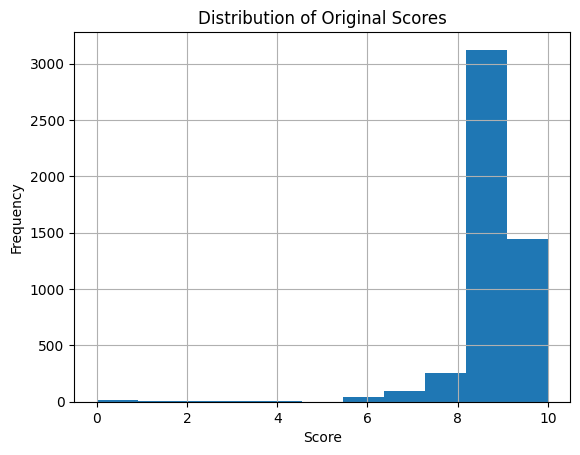

In [54]:
# Load X and y
X = np.load("data/X_train_original.npy")
y = np.load("data/y_train_original.npy")
X_test = np.load("data/X_test.npy")

# KDE plot for scores
y_s = pd.Series(y)
y_s.hist(bins=11)
plt.title("Distribution of Original Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

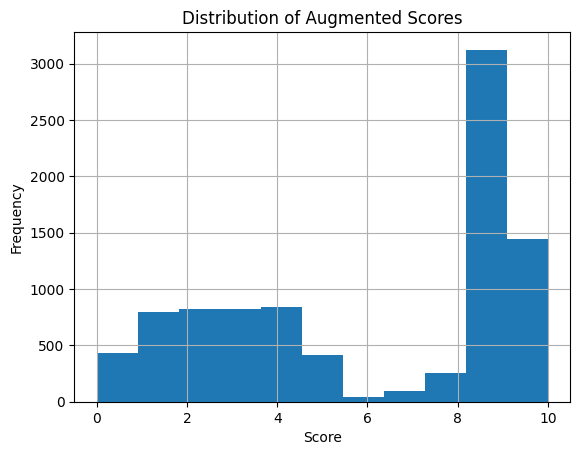

In [3]:
# Load X and y
X = np.load("data/X_train_augmented.npy")
y = np.load("data/y_train_augmented.npy")
X_test = np.load("data/X_test.npy")

# KDE plot for scores
y_s = pd.Series(y)
y_s.hist(bins=11)
plt.title("Distribution of Augmented Scores")
plt.xlabel("Score") 
plt.ylabel("Frequency")
plt.show()

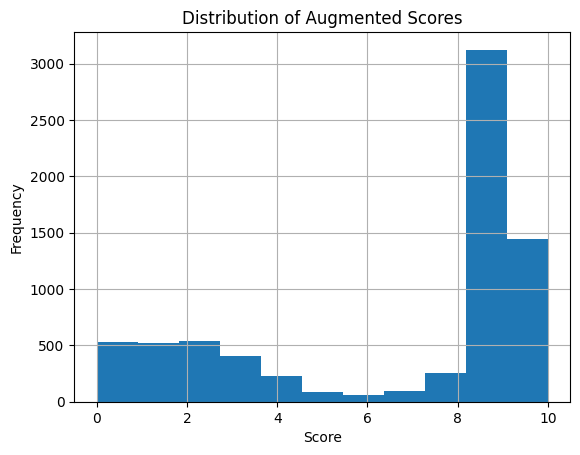

In [55]:
# Load X and y
X = np.load("data/old_data/X_train_augmented.npy")
y = np.load("data/old_data/y_train_augmented.npy")
X_test = np.load("data/X_test.npy")

# KDE plot for scores
y_s = pd.Series(y)
y_s.hist(bins=11)
plt.title("Distribution of Augmented Scores")
plt.xlabel("Score") 
plt.ylabel("Frequency")
plt.show()

In [4]:
y_s.value_counts()

9.0     3123
10.0    1442
4.0      841
3.0      822
2.0      821
1.0      798
0.0      428
5.0      414
8.0      259
7.0       95
6.0       45
9.5        1
Name: count, dtype: int64

### Metric and Prompt-Response Similarity

In [5]:
# X shape: (N, 1536) where 768 text | 768 metric
d = X.shape[1] // 2

text = X[:, :d].astype(np.float32)
metric = X[:, d:].astype(np.float32)

# Basic scalar similarities
cos_sim = np.sum(text * metric, axis=1) / (np.linalg.norm(text, axis=1) * np.linalg.norm(metric, axis=1) + 1e-8)
dot     = np.sum(text * metric, axis=1)
l2dist  = np.linalg.norm(text - metric, axis=1)

# Elementwise interactions
abs_diff = np.abs(text - metric)        # shape (N, 768)
prod     = text * metric                # shape (N, 768)

# Final feature matrix
X_feat = np.hstack([
    cos_sim.reshape(-1, 1),
    dot.reshape(-1, 1),
    l2dist.reshape(-1, 1),
    abs_diff,
    prod
])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X_feat, y, test_size=0.2, random_state=42)

from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective="reg:pseudohubererror",
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    device="gpu",
)

xgb.fit(X_train, y_train)
pred = xgb.predict(X_val)
print("XGBoost RMSE:", root_mean_squared_error(y_val, pred))

XGBoost RMSE: 2.558811902999878


In [20]:
from cuml import KernelRidge

reg = KernelRidge(alpha=0.01, kernel='rbf', gamma=0.01)
reg.fit(X_train, y_train)
pred = reg.predict(X_val)
print("KernalRidge RMSE:", root_mean_squared_error(y_val, pred))

KernalRidge RMSE: 2.4694582949383017


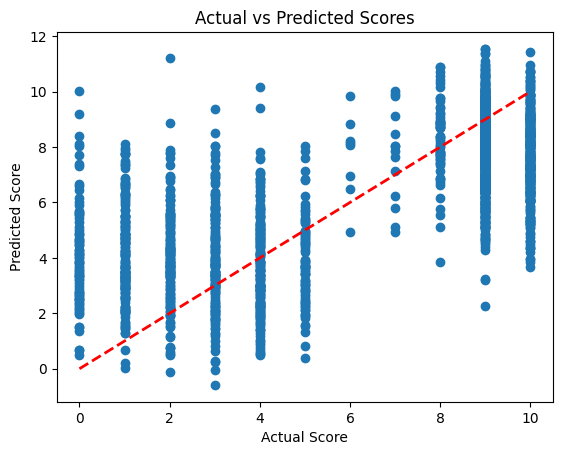

In [21]:
# Plot predicted vs actual
plt.scatter(y_val, pred)
plt.plot([0, 10], [0, 10], 'r--', lw=2)
plt.ylabel("Predicted Score")
plt.xlabel("Actual Score")
plt.title("Actual vs Predicted Scores")
plt.show()

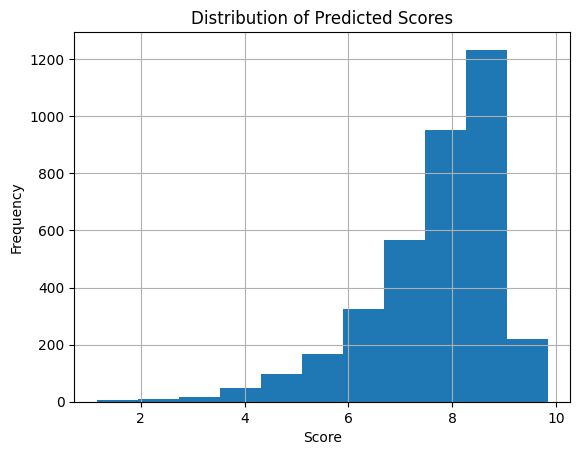

In [22]:
# X shape: (N, 1536) where 768 text | 768 metric

text = X_test[:, :d].astype(np.float32)
metric = X_test[:, d:].astype(np.float32)

# Basic scalar similarities
cos_sim = np.sum(text * metric, axis=1) / (np.linalg.norm(text, axis=1) * np.linalg.norm(metric, axis=1) + 1e-8)
dot     = np.sum(text * metric, axis=1)
l2dist  = np.linalg.norm(text - metric, axis=1)

# Elementwise interactions
abs_diff = np.abs(text - metric)        # shape (N, 768)
prod     = text * metric                # shape (N, 768)

# Final feature matrix
X_test = np.hstack([
    cos_sim.reshape(-1, 1),
    dot.reshape(-1, 1),
    l2dist.reshape(-1, 1),
    abs_diff,
    prod
])

# Prediction
pred_test = xgb.predict(X_test)
pred_test = np.clip(pred_test, 0, 10)

# KDE plot
y_s = pd.Series(pred_test)
y_s.hist(bins=11)
plt.title("Distribution of Predicted Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()